In [7]:
import torch
import numpy as np
import normflows as nf

from matplotlib import pyplot as plt

from tqdm import tqdm

In [22]:
import scanpy as sc
adata = sc.read("processed_files/glutamatergic_als_highly_var.h5ad")

/Users/shaunak/PycharmProjects/Single_Cell_Alzheimers/.venv/lib/python3.13/site-packages/scanpy/preprocessing/_pca/__init__.py:385: ImplicitModificationWarning: Setting element `.obsm['X_pca']` of view, initializing view as actual.
  adata.obsm[key_obsm] = X_pca


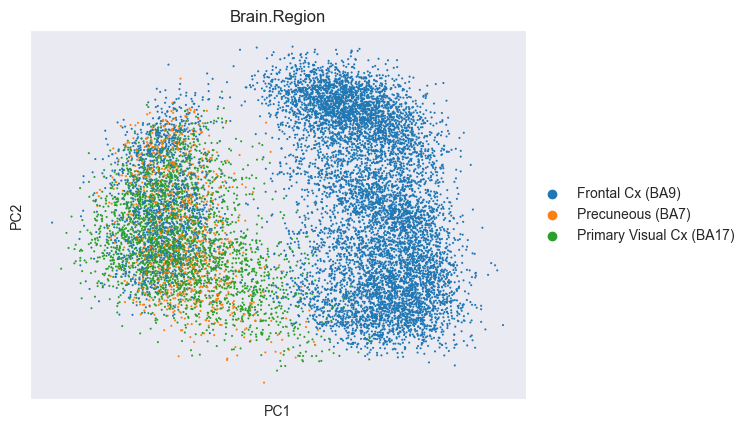

In [23]:
eg_subject = adata[adata.obs["donor_id"] == "35"]

sc.pp.pca(eg_subject, n_comps=2)
sc.pl.pca(eg_subject, color="Brain.Region")

In [24]:
data = eg_subject.X
data = torch.tensor(data.toarray())

In [26]:
data.shape

torch.Size([13083, 3000])

In [27]:
# Set up model

# Define 2D Gaussian base distribution
base = nf.distributions.base.DiagGaussian(3000)

# Define list of flows
num_layers = 32
flows = []
for i in range(num_layers):
    # Neural network with two hidden layers having 64 units each
    # Last layer is initialized by zeros making training more stable
    param_map = nf.nets.MLP([1, 512, 512, 8], init_zeros=True)
    # Add flow layer
    flows.append(nf.flows.AffineCouplingBlock(param_map))
    # Swap dimensions
    flows.append(nf.flows.Permute(2, mode='swap'))

# Construct flow model
model = nf.NormalizingFlow(base, flows)

In [28]:
model = model.to("mps")

In [13]:
target = nf.distributions.TwoMoons()

In [31]:
grid_size = 200
xx, yy = torch.meshgrid(torch.linspace(-3, 3, grid_size), torch.linspace(-3, 3, grid_size))
zz = torch.cat([xx.unsqueeze(2), yy.unsqueeze(2)], 2).view(-1, 2)
zz = zz.to("mps")
"""
log_prob = data.log_prob(zz).to('cpu').view(*xx.shape)
prob = torch.exp(log_prob)
prob[torch.isnan(prob)] = 0

plt.figure(figsize=(5, 15))
plt.pcolormesh(xx, yy, prob.data.numpy(), cmap='coolwarm')
plt.gca().set_aspect('equal', 'box')
plt.show()"""

"\nlog_prob = data.log_prob(zz).to('cpu').view(*xx.shape)\nprob = torch.exp(log_prob)\nprob[torch.isnan(prob)] = 0\n\nplt.figure(figsize=(5, 15))\nplt.pcolormesh(xx, yy, prob.data.numpy(), cmap='coolwarm')\nplt.gca().set_aspect('equal', 'box')\nplt.show()"

In [33]:
zz.shape

torch.Size([40000, 2])

In [32]:
# Plot initial flow distribution
model.eval()
log_prob = model.log_prob(zz).to('cpu').view(*xx.shape)
model.train()
prob = torch.exp(log_prob)
prob[torch.isnan(prob)] = 0

plt.figure(figsize=(5, 5))
plt.pcolormesh(xx, yy, prob.data.numpy(), cmap='coolwarm')
plt.gca().set_aspect('equal', 'box')
plt.show()

RuntimeError: linear(): input and weight.T shapes cannot be multiplied (40000x3 and 1x512)

 12%|█▏        | 498/4000 [00:22<02:42, 21.51it/s]

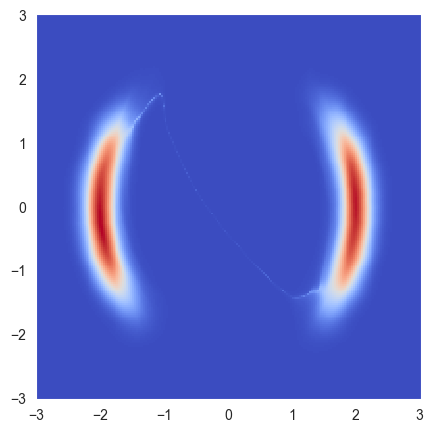

 25%|██▍       | 998/4000 [00:46<02:08, 23.34it/s]

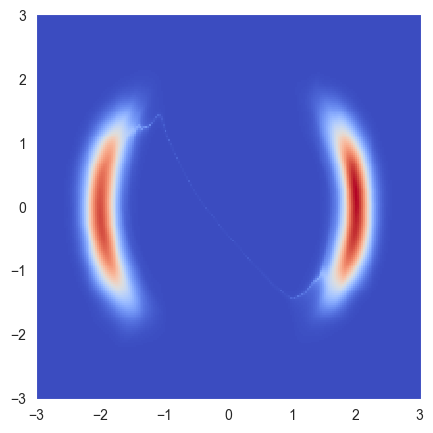

 37%|███▋      | 1499/4000 [01:09<01:54, 21.85it/s]

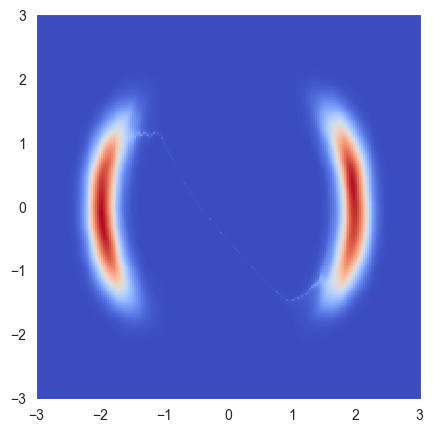

 50%|████▉     | 1999/4000 [01:32<01:20, 24.72it/s]

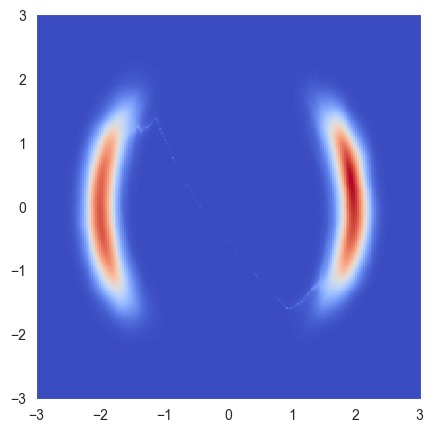

 62%|██████▏   | 2498/4000 [01:57<01:12, 20.61it/s]

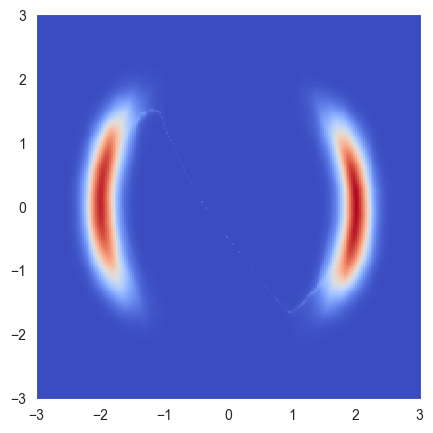

 75%|███████▍  | 2998/4000 [02:29<00:58, 17.19it/s]

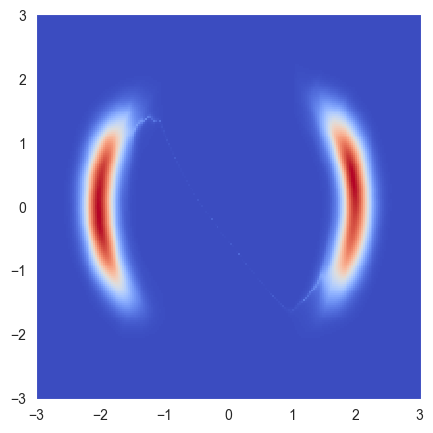

 87%|████████▋ | 3498/4000 [03:05<00:24, 20.91it/s]

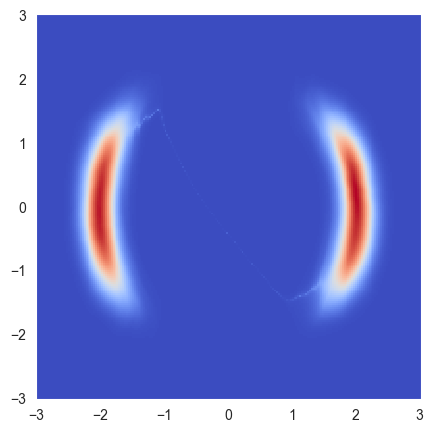

100%|█████████▉| 3998/4000 [03:39<00:00, 17.82it/s]

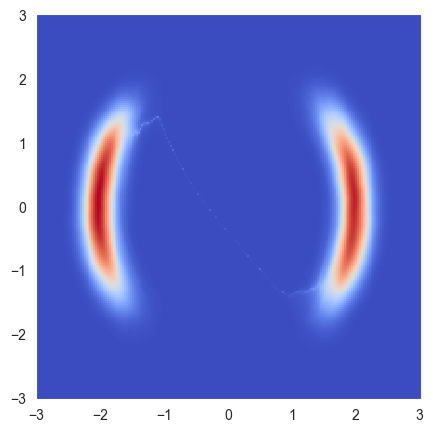

100%|██████████| 4000/4000 [03:41<00:00, 18.09it/s]


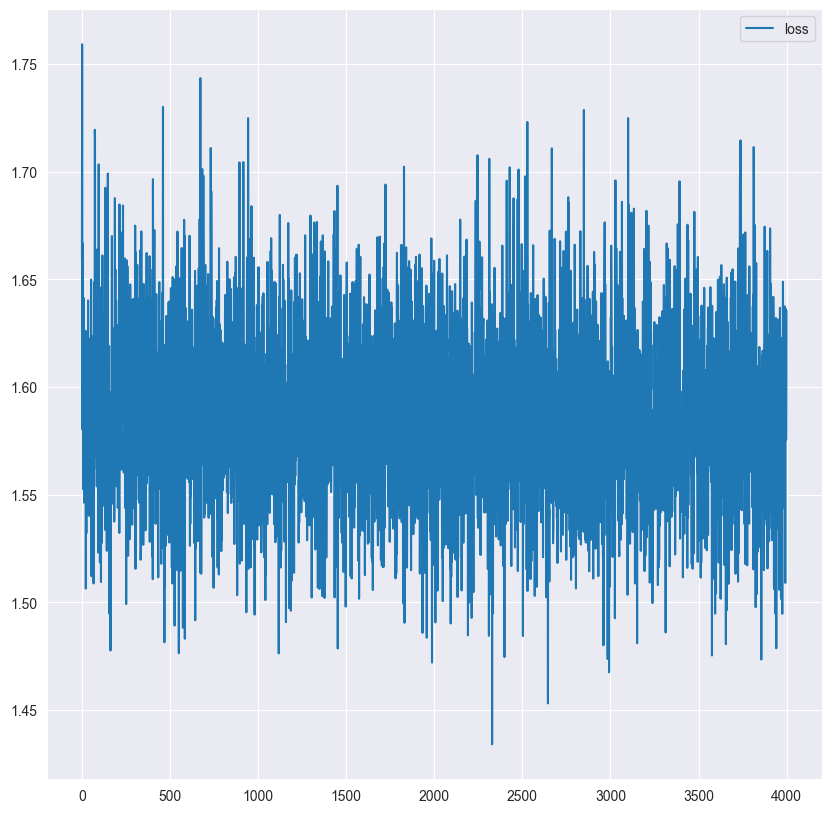

In [21]:
# Train model
max_iter = 4000
num_samples = 2 ** 9
show_iter = 500


loss_hist = np.array([])

optimizer = torch.optim.Adam(model.parameters(), lr=5e-4, weight_decay=1e-5)

for it in tqdm(range(max_iter)):
    optimizer.zero_grad()

    # Get training samples
    x = target.sample(num_samples).to("mps")

    # Compute loss
    loss = model.forward_kld(x)

    # Do backprop and optimizer step
    if ~(torch.isnan(loss) | torch.isinf(loss)):
        loss.backward()
        optimizer.step()

    # Log loss
    loss_hist = np.append(loss_hist, loss.to('cpu').data.numpy())

    # Plot learned distribution
    if (it + 1) % show_iter == 0:
        model.eval()
        log_prob = model.log_prob(zz)
        model.train()
        prob = torch.exp(log_prob.to('cpu').view(*xx.shape))
        prob[torch.isnan(prob)] = 0

        plt.figure(figsize=(5, 5))
        plt.pcolormesh(xx, yy, prob.data.numpy(), cmap='coolwarm')
        plt.gca().set_aspect('equal', 'box')
        plt.show()

# Plot loss
plt.figure(figsize=(10, 10))
plt.plot(loss_hist, label='loss')
plt.legend()
plt.show()